# Montreal Fire Risk Prediction

Here, We try to prepare a panel dataset for predicting neighborhood fire risk in Montreal.

**Output:**
- Binary target variable: Whether a neighborhood experiences at least one fire in a given month
- Spatial structure: 5km x 5km grid cells (maybe we can try 2.5km x 2.5km too? Or perhaps after Wednesday?)
- Temporal structure: Monthly time series (2005-09 onwards)
- Features: Building characteristics, temporal lags, seasonality, spatial lags

**Data Sources:**
1. Fire incidents: `Data/sim_combined_df.csv`
2. Buildings: `Data/montreal_dataset_v1.geojson`
3. Admin boundaries: `Data/EKUE_ASSESSMENTS_DATA/limites-administratives-agglomeration-nad83.geojson`

## Imports

In [1]:
import os
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import box
from shapely.ops import unary_union
import warnings
warnings.filterwarnings('ignore')


## Load Data

In [2]:
pwd

'/content'

In [3]:

from google.colab import drive
drive.mount('/content/drive')
#%cd "/content/drive/MyDrive/MCGILL_PROJECT_CAPSTONE/Capstone Project- McGill/Data/"
#%cd "/content/drive/MyDrive/Capstone Project- McGill/Data/"
%cd "/content/drive/MyDrive/Sam_McGill_Project_Team3"

os.getcwd()
#os.chdir("/mnt/g/My Drive/Capstone Project- McGill")

os.getcwd()

Mounted at /content/drive
/content/drive/MyDrive/Sam_McGill_Project_Team3


'/content/drive/MyDrive/Sam_McGill_Project_Team3'

### Buildings Data

In [4]:
# buildings
#buildings = gpd.read_file('Data/montreal_dataset_v1.geojson', engine='pyogrio')
buildings = gpd.read_file('montreal_dataset_v1.geojson', engine='pyogrio')

print(f"Initial buildings: {len(buildings):,}")
print(f"Original CRS: {buildings.crs}")

# invalid construction years (9999 = missing)
buildings = buildings[buildings['ANNEE_CONS'] != 9999]
print(f"After filtering invalid construction years: {len(buildings):,}")

# Here, I convert to NAD83/MTM8 (EPSG:32188) to be in line with the projection used by city of Montreal

buildings = buildings.to_crs(epsg=32188)
print(f"Converted to CRS: {buildings.crs}")

Initial buildings: 480,243
Original CRS: EPSG:4326
After filtering invalid construction years: 466,775
Converted to CRS: EPSG:32188


### Administrative Boundaries

In [5]:
# Admin boundaries

#admin_bounds = gpd.read_file('Data/EKUE_ASSESSMENTS_DATA/limites-administratives-agglomeration-nad83.geojson')
admin_bounds = gpd.read_file('/content/drive/MyDrive/Sam_McGill_Project_Team3/limites-administratives-agglomeration-nad83 (2).geojson')

# Let's try to fix geometry issues
admin_bounds['geometry'] = admin_bounds.buffer(0)

# Convert to NAD83/MTM8
admin_bounds = admin_bounds.to_crs(epsg=32188)

# Unified boundary
boundary_union = unary_union(admin_bounds.geometry)

print(f"Administrative boundaries loaded: {len(admin_bounds)} areas")
print(f"CRS: {admin_bounds.crs}")

Administrative boundaries loaded: 34 areas
CRS: EPSG:32188


## Create Spatial Grid (FishNet)

In [6]:
def make_fishnet(polygon, cell_size_m=5000, buffer_m=500):
    """
    Regular grid of cells over a polygon area.

    Parameters:
    -----------
    polygon : shapely geometry
        Polygon to create grid over
    cell_size_m : int
        Size of each grid cell in meters (default: 5000m = 5km)- we can change this later if we want
    buffer_m : int
        Buffer distance in meters (default: 500m)

    Returns:
    --------
    geopandas.GeoDataFrame
        Grid cells with columns: row, col, geometry, area_km2, cell_id
    """
    # Apply buffer
    poly = polygon.buffer(buffer_m) if buffer_m != 0 else polygon
    minx, miny, maxx, maxy = poly.bounds

    # Calculate grid dimensions
    n_cols = math.ceil((maxx - minx) / cell_size_m)
    n_rows = math.ceil((maxy - miny) / cell_size_m)

    print(f"Creating grid: {n_rows} rows x {n_cols} cols")

    # Create grid cells
    cells = []
    for r in range(n_rows):
        y1 = miny + r * cell_size_m
        y2 = y1 + cell_size_m
        for c in range(n_cols):
            x1 = minx + c * cell_size_m
            x2 = x1 + cell_size_m
            cell = box(x1, y1, x2, y2)
            if cell.intersects(poly):
                cells.append((r, c, cell.intersection(poly)))

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(cells, columns=["row", "col", "geometry"], crs="EPSG:32188")
    gdf["area_km2"] = gdf.geometry.area / 1e6
    gdf["cell_id"] = gdf["row"].astype(str) + "_" + gdf["col"].astype(str)

    print(f"Created {len(gdf)} grid cells")

    return gdf



In [7]:
# Create grid with 5km cells
CELL_SIZE = 2500 # 5000   # meters (5 km)
BUFFER_SIZE = 500  # meters

grid = make_fishnet(
    polygon=boundary_union,
    cell_size_m=CELL_SIZE,
    buffer_m=BUFFER_SIZE
)

print(f"\nGrid statistics:")
print(f"Total cells: {len(grid):,}")
print(f"Mean area: {grid['area_km2'].mean():.2f} km²")
print(f"Total area: {grid['area_km2'].sum():.2f} km²")

Creating grid: 15 rows x 17 cols
Created 142 grid cells

Grid statistics:
Total cells: 142
Mean area: 4.85 km²
Total area: 688.23 km²


## Prepare Fire Data

In [8]:
# Fire incidents

#fires = pd.read_csv('Data/sim_combined_df.csv', engine='python')
fires = pd.read_csv('/content/drive/MyDrive/Sam_McGill_Project_Team3/sim_combined_df.csv', engine='python')

print(f"Total fire incidents: {len(fires):,}")

# Rename coordinate columns
fires.rename(columns={'LATITUDE': 'latitude', 'LONGITUDE': 'longitude'}, inplace=True)

# GeoDataFrame with WGS84 coordinates
fires_geo = gpd.GeoDataFrame(
    fires,
    geometry=gpd.points_from_xy(fires['longitude'], fires['latitude']),
    crs=4326
)

# Convert to NAD83/MTM8 to match grid
fires_geo = fires_geo.to_crs(epsg=32188)

# Convert date column and extract year-month
fires_geo['CREATION_DATE_FIXED'] = pd.to_datetime(fires_geo['CREATION_DATE_FIXED'])
fires_geo['year_month'] = fires_geo['CREATION_DATE_FIXED'].dt.to_period('M').astype(str)

print(f"Date range: {fires_geo['CREATION_DATE_FIXED'].min()} to {fires_geo['CREATION_DATE_FIXED'].max()}")
print(f"Year-month range: {fires_geo['year_month'].min()} to {fires_geo['year_month'].max()}")

Total fire incidents: 395,971
Date range: 2005-01-01 00:00:00 to 2025-09-21 00:00:00
Year-month range: 2005-01 to 2025-09


## Spatial Joins

### Join Buildings to Grid

In [9]:
# Convert building polygons to points

# Please note:
# I use the representative_point() method here, which is similar to centroid() but with an important difference.
# Technically, centroid() returns the geometric center of a polygon, which may fall outside the polygon's boundaries (especially for complex or irregular shapes- so we can't be so sure)
# However, representative_point() returns a point that is guaranteed to be inside the polygon's boundaries.
# Based on my quick research, it's often close to the centroid, but will always be within the actual geometry.
# So, for our buildings data, this matters because we're doing spatial operations like checking which fire station
# zone a building is in, so we need a point that's actually inside the building footprint.
# The risk of using centroid is that if the building polygons have irregular shapes, the centroid might fall outside (for example, U-shaped buildings or buildings with courtyards).
# SO, to ensures more accurate spatial joins and distance calculations, I use representative_point().


print("Converting buildings to points...")
buildings_points = buildings.copy()
buildings_points['geometry'] = buildings.representative_point()

# Spatial join
print("Joining buildings to grid...")
bld_in_grid = gpd.sjoin(
    buildings_points,
    grid,
    how="left",
    predicate="within"
)

print(f"Buildings successfully joined: {bld_in_grid['cell_id'].notna().sum():,}")
print(f"Buildings without cell assignment: {bld_in_grid['cell_id'].isna().sum():,}")

# Aggregate building attributes by cell
print("Aggregating building features by cell...")
bld_agg = (
    bld_in_grid.groupby('cell_id')
    .agg(
        num_buildings=('geometry', 'count'),
        avg_floors=('ETAGE_HORS', 'mean'),
        median_construction_year=('ANNEE_CONS', 'median')
    )
    .reset_index()
)

print(f"Cells with buildings: {len(bld_agg):,}")
print(f"\nBuilding statistics:")
print(bld_agg.describe())

Converting buildings to points...
Joining buildings to grid...
Buildings successfully joined: 466,775
Buildings without cell assignment: 0
Aggregating building features by cell...
Cells with buildings: 115

Building statistics:
       num_buildings  avg_floors  median_construction_year
count     115.000000  115.000000                115.000000
mean     4058.913043    1.606130               1969.056522
std      4296.599083    1.039919                 21.063580
min         1.000000    0.000000               1868.000000
25%       398.500000    1.380378               1958.500000
50%      3345.000000    1.568486               1968.000000
75%      5764.500000    1.722193               1984.000000
max     23916.000000   12.000000               2014.000000


### Join Fires to Grid

In [10]:
# Spatial join
print("Joining fires to grid...")
fire_in_grid = gpd.sjoin(
    fires_geo,
    grid,
    how="left",
    predicate="within"
)

print(f"Fires successfully joined: {fire_in_grid['cell_id'].notna().sum():,}")
print(f"Fires without cell assignment: {fire_in_grid['cell_id'].isna().sum():,}")

# Count fires per cell and month
print("Counting fires per cell and month...")
fire_counts = (
    fire_in_grid.groupby(['cell_id', 'year_month'])
    .size()
    .reset_index(name='fire_count')
)

print(f"Total cell-month combinations with fires: {len(fire_counts):,}")

Joining fires to grid...
Fires successfully joined: 395,963
Fires without cell assignment: 8
Counting fires per cell and month...
Total cell-month combinations with fires: 23,819


## Panel Dataset

In [11]:
# Filter time range (September 2005 onwards)
print("Filtering time range...")
fire_counts = fire_counts[fire_counts['year_month'] >= '2005-09']
print(f"After filtering: {len(fire_counts):,} cell-month observations")

# Let's use pivot and stack (not MultiIndex)
print("Creating Panel Dataset...")
pivot_fire = fire_counts.pivot(
    index='cell_id',
    columns='year_month',
    values='fire_count'
)

# Fill missing values with 0 (months with no fires)
pivot_fire = pivot_fire.fillna(0)

print(f"Cells: {len(pivot_fire)}")
print(f"Months: {len(pivot_fire.columns)}")
print(f"Total observations: {len(pivot_fire) * len(pivot_fire.columns):,}")

# Stack back to long format (ensures ALL cell-month combinations present)
final_fire = pivot_fire.stack().reset_index(name="number_of_fires")

print(f"\nPanel Dataset created: {len(final_fire):,} rows")

Filtering time range...
After filtering: 23,053 cell-month observations
Creating Panel Dataset...
Cells: 115
Months: 241
Total observations: 27,715

Panel Dataset created: 27,715 rows


## Merge Features and Create Target Variable

In [12]:
# We need to merge temporal fire counts with static building features
print("Merging building features...")
final_df = final_fire.merge(bld_agg, on='cell_id', how='left')

# Fill NaN values for cells with no buildings
final_df['num_buildings'] = final_df['num_buildings'].fillna(0)
final_df['avg_floors'] = final_df['avg_floors'].fillna(final_df['avg_floors'].median())
final_df['median_construction_year'] = final_df['median_construction_year'].fillna(
    final_df['median_construction_year'].median()
)

# Convert year_month to Period type for easier manipulation
final_df['year_month'] = pd.PeriodIndex(final_df['year_month'], freq='M')

# Create binary target variable: 1 if any fires, 0 otherwise
final_df['Target_Variable'] = (final_df['number_of_fires'] > 0).astype(int)

print(f"\nFinal dataframe shape: {final_df.shape}")
print(f"\nColumns: {list(final_df.columns)}")
print(f"\nTarget variable distribution:")
print(final_df['Target_Variable'].value_counts(normalize=True))
print(f"\nFirst few rows:")
print(final_df.head(10))

Merging building features...

Final dataframe shape: (27715, 7)

Columns: ['cell_id', 'year_month', 'number_of_fires', 'num_buildings', 'avg_floors', 'median_construction_year', 'Target_Variable']

Target variable distribution:
Target_Variable
1    0.831788
0    0.168212
Name: proportion, dtype: float64

First few rows:
  cell_id year_month  number_of_fires  num_buildings  avg_floors  \
0     0_1    2005-09              1.0           37.0    1.378378   
1     0_1    2005-10              1.0           37.0    1.378378   
2     0_1    2005-11              0.0           37.0    1.378378   
3     0_1    2005-12              0.0           37.0    1.378378   
4     0_1    2006-01              0.0           37.0    1.378378   
5     0_1    2006-02              1.0           37.0    1.378378   
6     0_1    2006-03              1.0           37.0    1.378378   
7     0_1    2006-04              0.0           37.0    1.378378   
8     0_1    2006-05              0.0           37.0    1.378378  

## Temporal Lags (Feature Engineering)

In [13]:
# Sort by cell and time for lag computation
print("Creating temporal lag features...")
final_df = final_df.sort_values(['cell_id', 'year_month'])

# Create lagged fire count variables (1, 2, 3, 6, 12 months)
for lag in [1, 2, 3, 6, 12]:
    final_df[f'fires_lag_{lag}m'] = (
        final_df
        .groupby('cell_id')['number_of_fires']
        .shift(lag)
        .fillna(0)
    )
    print(f"Created fires_lag_{lag}m")

# Lagged binary target variables (for autoregressive models)
for lag in [1, 2, 3]:
    final_df[f'target_lag_{lag}m'] = (
        final_df
        .groupby('cell_id')['Target_Variable']
        .shift(lag)
        .fillna(0)
    )
    print(f"Created target_lag_{lag}m")

print(f"\nTemporal lag features added successfully")
print(f"New shape: {final_df.shape}")

Creating temporal lag features...
Created fires_lag_1m
Created fires_lag_2m
Created fires_lag_3m
Created fires_lag_6m
Created fires_lag_12m
Created target_lag_1m
Created target_lag_2m
Created target_lag_3m

Temporal lag features added successfully
New shape: (27715, 15)


## Seasonality

In [14]:
# Extract month and year
print("Creating seasonality features...")
final_df['month'] = final_df['year_month'].dt.month
final_df['year'] = final_df['year_month'].dt.year

# Sine/cosine transformations for circular encoding
final_df['month_sin'] = np.sin(2 * np.pi * final_df['month'] / 12)
final_df['month_cos'] = np.cos(2 * np.pi * final_df['month'] / 12)

print("Seasonality features created:")
print("  - month (1-12)")
print("  - year")
print("  - month_sin (circular encoding)")
print("  - month_cos (circular encoding)")

#  Sample values for different months
print("\nSample seasonality values:")
example_months = final_df[['month', 'month_sin', 'month_cos']].drop_duplicates().sort_values('month')
print(example_months.head(12))

Creating seasonality features...
Seasonality features created:
  - month (1-12)
  - year
  - month_sin (circular encoding)
  - month_cos (circular encoding)

Sample seasonality values:
    month     month_sin     month_cos
4       1  5.000000e-01  8.660254e-01
5       2  8.660254e-01  5.000000e-01
6       3  1.000000e+00  6.123234e-17
7       4  8.660254e-01 -5.000000e-01
8       5  5.000000e-01 -8.660254e-01
9       6  1.224647e-16 -1.000000e+00
10      7 -5.000000e-01 -8.660254e-01
11      8 -8.660254e-01 -5.000000e-01
0       9 -1.000000e+00 -1.836970e-16
1      10 -8.660254e-01  5.000000e-01
2      11 -5.000000e-01  8.660254e-01
3      12 -2.449294e-16  1.000000e+00


## Spatial Lags

In [15]:
# Build neighbor mapping (4-neighbor: North, South, East, West)
# Only include neighbors that actually exist in the dataset
print("Building spatial adjacency structure...")
neighbor_map = {}

# Get all valid cell_ids as a set for fast lookup
valid_cells = set(final_df['cell_id'].unique())
# sam - start(1)
#cellsLst = []
#print("start - lst cells")
# sam - end(1)
for cell_id in valid_cells:
    row_str, col_str = cell_id.split('_')
    row, col = int(row_str), int(col_str)
    # sam - start(2)
    #cellsLst.append([row, col])
    #print([row, col])
    #print("end - lst cells")
    # sam - end(2)
    # Candidate neighbors (4-neighbor: cardinal directions)
    candidates = [
        f"{row-1}_{col}",  # North
        f"{row+1}_{col}",  # South
        f"{row}_{col-1}",  # West
        f"{row}_{col+1}"   # East
    ]

    # Keep only neighbors that actually exist in the dataset
    neighbors = [n for n in candidates if n in valid_cells]
    neighbor_map[cell_id] = neighbors

print(f"Neighbor map created for {len(neighbor_map):,} cells")

# Analyze neighbor distribution to understand edge effects
neighbor_counts = {cell: len(neighbors) for cell, neighbors in neighbor_map.items()}
print("\nNeighbor count distribution:")
print(f"  Cells with 2 neighbors (corners): {sum(1 for c in neighbor_counts.values() if c == 2)}")
print(f"  Cells with 3 neighbors (edges): {sum(1 for c in neighbor_counts.values() if c == 3)}")
print(f"  Cells with 4 neighbors (interior): {sum(1 for c in neighbor_counts.values() if c == 4)}")

# Sam [19-Oct-2025] - start
print(f"  Cells with 1 neighbor (corners): {sum(1 for c in neighbor_counts.values() if c == 1)}")

ttl = 0
for i in range(1,5):
  ttl += sum(1 for c in neighbor_counts.values() if c == i)
print(ttl)
# Sam [19-Oct-2025] - end

Building spatial adjacency structure...
Neighbor map created for 115 cells

Neighbor count distribution:
  Cells with 2 neighbors (corners): 19
  Cells with 3 neighbors (edges): 22
  Cells with 4 neighbors (interior): 70
  Cells with 1 neighbor (corners): 4
115


In [16]:
# Compute spatial lag with TEMPORAL LAG to avoid data leakage

print("\nComputing spatial lag features with temporal lag (this may take a few minutes)...")


def get_neighbor_fires_lagged(row):
    """
    Sum of fire counts in neighboring cells from PREVIOUS month.
    This avoids data leakage by not using concurrent fire information.
    """
    cell = row['cell_id']
    current_period = row['year_month']
    neighbors = neighbor_map.get(cell, [])

    if len(neighbors) == 0:
        return 0

    # Get previous month (temporal lag)
    current_date = pd.to_datetime(str(current_period))
    previous_period = (current_date - pd.DateOffset(months=1)).to_period('M')

    neighbor_data = final_df[
        (final_df['cell_id'].isin(neighbors)) &
        (final_df['year_month'] == previous_period)
    ]

    return neighbor_data['number_of_fires'].sum()

def get_neighbor_targets_lagged(row):
    """
    Number of neighboring cells with fires in PREVIOUS month.
    This avoids data leakage by not using concurrent fire information.
    """
    cell = row['cell_id']
    current_period = row['year_month']
    neighbors = neighbor_map.get(cell, [])

    if len(neighbors) == 0:
        return 0

    # Get previous month (temporal lag)
    current_date = pd.to_datetime(str(current_period))
    previous_period = (current_date - pd.DateOffset(months=1)).to_period('M')

    neighbor_data = final_df[
        (final_df['cell_id'].isin(neighbors)) &
        (final_df['year_month'] == previous_period)
    ]

    return neighbor_data['Target_Variable'].sum()

def get_neighbor_count(row):
    """Number of valid neighbors for this cell (to identify border cells)"""
    cell = row['cell_id']
    neighbors = neighbor_map.get(cell, [])
    return len(neighbors)

# Spatial lag computation
print("Computing spatial lag features...")
final_df['neighbors_fires_lag1m'] = final_df.apply(get_neighbor_fires_lagged, axis=1)
final_df['neighbors_target_lag1m'] = final_df.apply(get_neighbor_targets_lagged, axis=1)
final_df['neighbor_count'] = final_df.apply(get_neighbor_count, axis=1)

# Normalized version (average per neighbor to handle edge effects)
final_df['neighbors_fires_avg'] = final_df['neighbors_fires_lag1m'] / final_df['neighbor_count']
final_df['neighbors_fires_avg'] = final_df['neighbors_fires_avg'].fillna(0)

print("\nSpatial lag features created:")
print("   neighbors_fires_lag1m (sum of fires in adjacent cells from previous month)")
print("   neighbors_target_lag1m (count of adjacent cells with fires from previous month)")
print("   neighbor_count (number of valid neighbors - identifies border cells)")
print("   neighbors_fires_avg (average fires per neighbor - normalized for edge effects)")

print(f"\nSpatial lag statistics:")
print(final_df[['neighbors_fires_lag1m', 'neighbors_target_lag1m', 'neighbor_count', 'neighbors_fires_avg']].describe())




Computing spatial lag features with temporal lag (this may take a few minutes)...
Computing spatial lag features...

Spatial lag features created:
   neighbors_fires_lag1m (sum of fires in adjacent cells from previous month)
   neighbors_target_lag1m (count of adjacent cells with fires from previous month)
   neighbor_count (number of valid neighbors - identifies border cells)
   neighbors_fires_avg (average fires per neighbor - normalized for edge effects)

Spatial lag statistics:
       neighbors_fires_lag1m  neighbors_target_lag1m  neighbor_count  \
count           27715.000000            27715.000000    27715.000000   
mean               53.026123                2.984268        3.373913   
std                60.316412                1.105647        0.879352   
min                 0.000000                0.000000        1.000000   
25%                14.000000                2.000000        3.000000   
50%                30.000000                3.000000        4.000000   
75%     

### Visualize Edge Effects and Spatial Structure

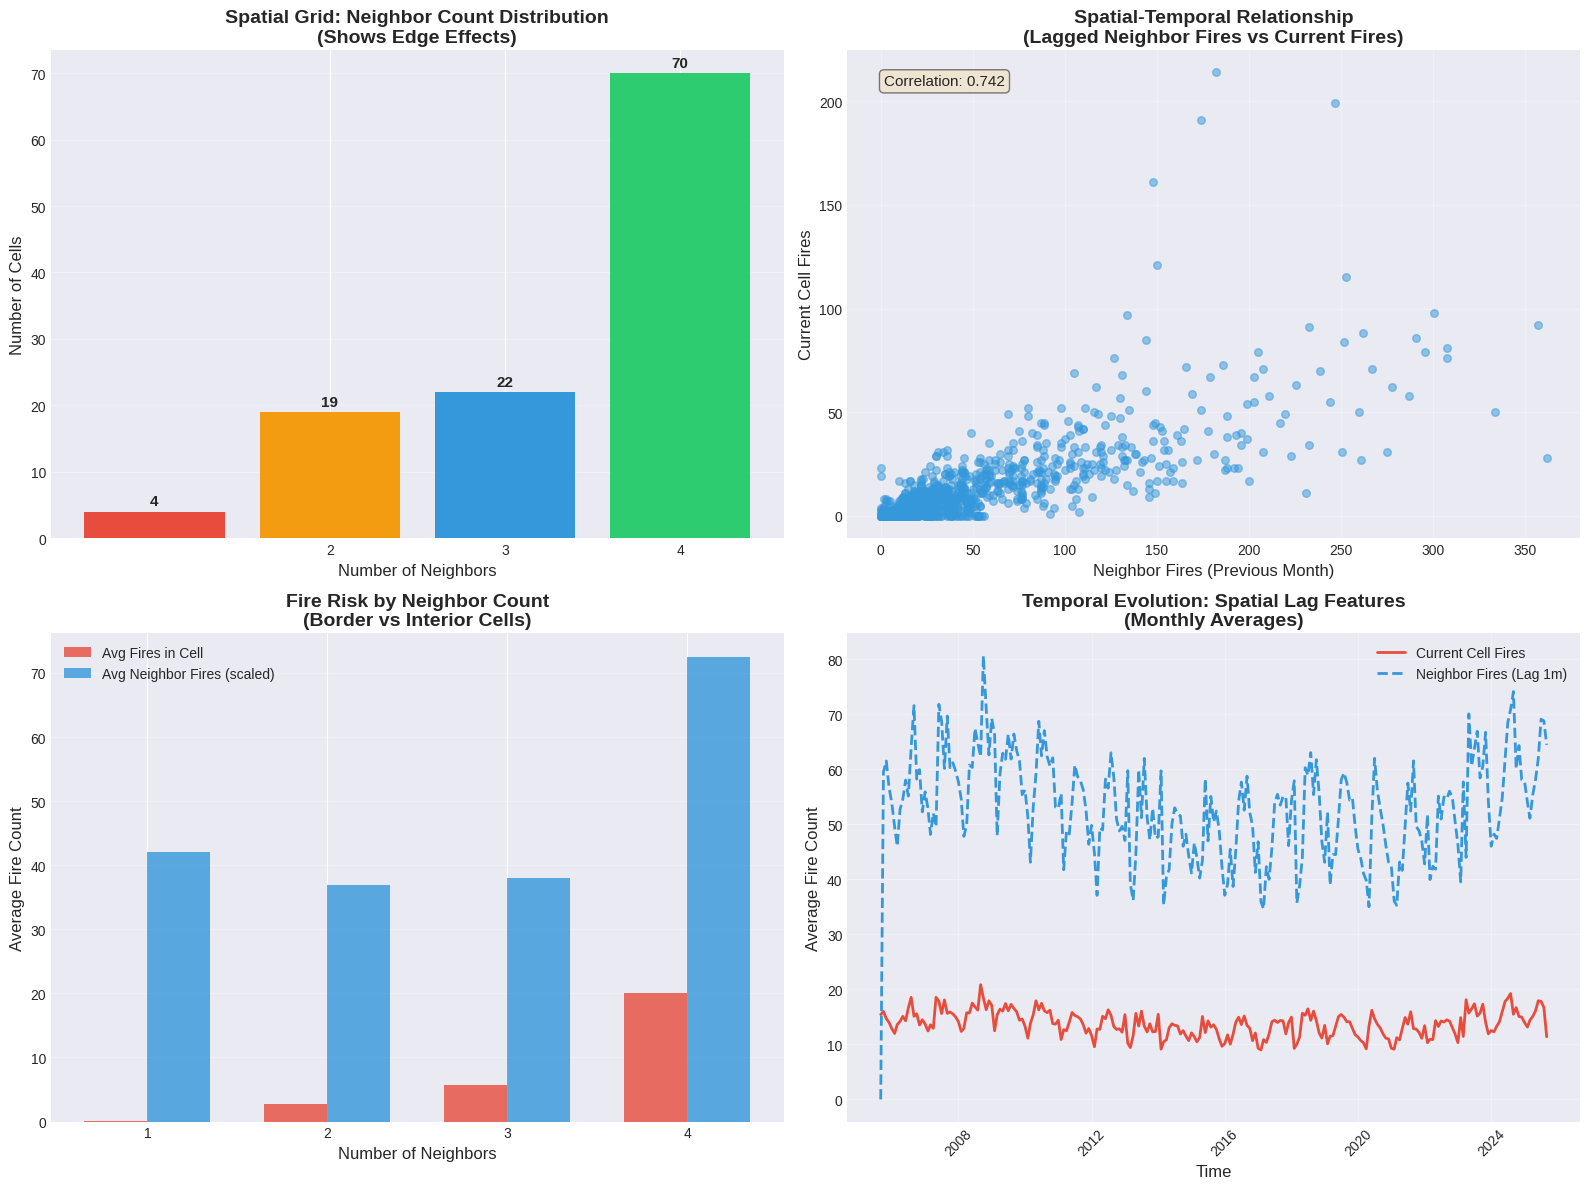

In [17]:

# Style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Neighbor Count Distribution
ax1 = axes[0, 0]
neighbor_dist = final_df.groupby('cell_id')['neighbor_count'].first()
counts = neighbor_dist.value_counts().sort_index()
ax1.bar(counts.index, counts.values, color=['#e74c3c', '#f39c12', '#3498db', '#2ecc71'])
ax1.set_xlabel('Number of Neighbors', fontsize=12)
ax1.set_ylabel('Number of Cells', fontsize=12)
ax1.set_title('Spatial Grid: Neighbor Count Distribution\n(Shows Edge Effects)', fontsize=14, fontweight='bold')
ax1.set_xticks([2, 3, 4])
for i, v in enumerate(counts.values):
    ax1.text(counts.index[i], v + 0.5, str(v), ha='center', va='bottom', fontsize=11, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Spatial Lag Comparison: Original vs Lagged
ax2 = axes[0, 1]
# Sample a subset for visualization
sample_data = final_df.sample(min(1000, len(final_df)), random_state=42)
ax2.scatter(sample_data['neighbors_fires_lag1m'], sample_data['number_of_fires'],
           alpha=0.5, s=30, color='#3498db')
ax2.set_xlabel('Neighbor Fires (Previous Month)', fontsize=12)
ax2.set_ylabel('Current Cell Fires', fontsize=12)
ax2.set_title('Spatial-Temporal Relationship\n(Lagged Neighbor Fires vs Current Fires)',
             fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Correlation
corr = sample_data[['neighbors_fires_lag1m', 'number_of_fires']].corr().iloc[0, 1]
ax2.text(0.05, 0.95, f'Correlation: {corr:.3f}',
        transform=ax2.transAxes, fontsize=11,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
        verticalalignment='top')

# Edge Effect Analysis
ax3 = axes[1, 0]
edge_analysis = final_df.groupby('neighbor_count').agg({
    'number_of_fires': 'mean',
    'neighbors_fires_lag1m': 'mean',
    'neighbors_fires_avg': 'mean'
}).reset_index()

x = range(len(edge_analysis))
width = 0.35
ax3.bar([i - width/2 for i in x], edge_analysis['number_of_fires'],
       width, label='Avg Fires in Cell', color='#e74c3c', alpha=0.8)
ax3.bar([i + width/2 for i in x], edge_analysis['neighbors_fires_avg'].fillna(0) * 4,
       width, label='Avg Neighbor Fires (scaled)', color='#3498db', alpha=0.8)

ax3.set_xlabel('Number of Neighbors', fontsize=12)
ax3.set_ylabel('Average Fire Count', fontsize=12)
ax3.set_title('Fire Risk by Neighbor Count\n(Border vs Interior Cells)',
             fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(edge_analysis['neighbor_count'])
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Time Series: Spatial Lag Feature Evolution
ax4 = axes[1, 1]
# Aggregate by month
monthly_spatial = final_df.groupby('year_month').agg({
    'neighbors_fires_lag1m': 'mean',
    'number_of_fires': 'mean'
}).reset_index()

# Convert period to datetime for plotting
monthly_spatial['date'] = monthly_spatial['year_month'].dt.to_timestamp()

ax4.plot(monthly_spatial['date'], monthly_spatial['number_of_fires'],
        label='Current Cell Fires', linewidth=2, color='#e74c3c')
ax4.plot(monthly_spatial['date'], monthly_spatial['neighbors_fires_lag1m'],
        label='Neighbor Fires (Lag 1m)', linewidth=2, color='#3498db', linestyle='--')

ax4.set_xlabel('Time', fontsize=12)
ax4.set_ylabel('Average Fire Count', fontsize=12)
ax4.set_title('Temporal Evolution: Spatial Lag Features\n(Monthly Averages)',
             fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



In [18]:
# Summary statistics
print("\n" + "="*80)
print("EDGE EFFECTS ANALYSIS")
print("="*80)
print("\nFire statistics by neighbor count:")
edge_stats = final_df.groupby('neighbor_count').agg({
    'number_of_fires': ['mean', 'median', 'std'],
    'neighbors_fires_lag1m': ['mean', 'median'],
    'cell_id': 'nunique'
}).round(2)
edge_stats.columns = ['_'.join(col).strip() for col in edge_stats.columns.values]
print(edge_stats)




EDGE EFFECTS ANALYSIS

Fire statistics by neighbor count:
                number_of_fires_mean  number_of_fires_median  \
neighbor_count                                                 
1                               0.10                     0.0   
2                               2.71                     0.0   
3                               5.72                     4.0   
4                              20.14                    14.0   

                number_of_fires_std  neighbors_fires_lag1m_mean  \
neighbor_count                                                    
1                              0.35                       10.51   
2                              4.48                       18.49   
3                              5.94                       28.52   
4                             24.18                       72.53   

                neighbors_fires_lag1m_median  cell_id_nunique  
neighbor_count                                                 
1                        

## Data Quality Checks

In [19]:
# Missing values
print("\nMissing values:")
missing = final_df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("   No missing values found")




Missing values:
   No missing values found


In [20]:
# Duplicate records
print("\nDuplicate records:")
duplicates = final_df.duplicated(subset=['cell_id', 'year_month']).sum()
print(f"   Duplicate rows: {duplicates}")
if duplicates > 0:
    print("   Removing duplicates...")
    final_df = final_df.drop_duplicates(subset=['cell_id', 'year_month'])




Duplicate records:
   Duplicate rows: 0


In [21]:
# Temporal coverage
print("\nTemporal coverage:")
coverage = final_df.groupby('cell_id')['year_month'].count()
print(f"   Min observations per cell: {coverage.min()}")
print(f"   Max observations per cell: {coverage.max()}")
print(f"   Mean observations per cell: {coverage.mean():.2f}")




Temporal coverage:
   Min observations per cell: 241
   Max observations per cell: 241
   Mean observations per cell: 241.00


In [22]:
# Class balance
print("\nTarget variable class balance:")
class_dist = final_df['Target_Variable'].value_counts(normalize=True)
print(f"   No fire (0): {class_dist[0]:.2%}")
print(f"   Fire (1): {class_dist[1]:.2%}")




Target variable class balance:
   No fire (0): 16.82%
   Fire (1): 83.18%


In [23]:
# Data types
print("\nData types:")
print(final_df.dtypes)




Data types:
cell_id                        object
year_month                  period[M]
number_of_fires               float64
num_buildings                 float64
avg_floors                    float64
median_construction_year      float64
Target_Variable                 int64
fires_lag_1m                  float64
fires_lag_2m                  float64
fires_lag_3m                  float64
fires_lag_6m                  float64
fires_lag_12m                 float64
target_lag_1m                 float64
target_lag_2m                 float64
target_lag_3m                 float64
month                           int64
year                            int64
month_sin                     float64
month_cos                     float64
neighbors_fires_lag1m         float64
neighbors_target_lag1m          int64
neighbor_count                  int64
neighbors_fires_avg           float64
dtype: object


In [24]:
# Summary statistics
print("\nSummary statistics:")
print(final_df.describe())


Summary statistics:
       number_of_fires  num_buildings    avg_floors  median_construction_year  \
count     27715.000000   27715.000000  27715.000000              27715.000000   
mean         13.801479    4057.730435      1.529465               1970.300000   
std          20.727958    4279.061658      0.318790                 17.754658   
min           0.000000       0.000000      0.041667               1920.000000   
25%           2.000000     367.000000      1.383245               1959.000000   
50%           7.000000    3345.000000      1.568368               1968.000000   
75%          18.000000    5799.000000      1.717582               1984.000000   
max         242.000000   23916.000000      3.069767               2014.000000   

       Target_Variable  fires_lag_1m  fires_lag_2m  fires_lag_3m  \
count     27715.000000  27715.000000  27715.000000  27715.000000   
mean          0.831788     13.754176     13.684719     13.610752   
std           0.374061     20.715315     20.6

## Final Dataset Summary

In [25]:
print("="*80)
print("FINAL DATASET SUMMARY")
print("="*80)

print(f"\nDataset shape: {final_df.shape[0]:,} rows x {final_df.shape[1]} columns")

print(f"\nSpatial coverage:")
print(f"  - Unique cells: {final_df['cell_id'].nunique():,}")
print(f"  - Cell size: {CELL_SIZE}m x {CELL_SIZE}m")

print(f"\nTemporal coverage:")
print(f"  - Start date: {final_df['year_month'].min()}")
print(f"  - End date: {final_df['year_month'].max()}")
print(f"  - Total months: {final_df['year_month'].nunique()}")

print(f"\nTarget variable:")
print(f"  - Total fire events: {final_df['Target_Variable'].sum():,}")
print(f"  - Fire rate: {final_df['Target_Variable'].mean():.2%}")

print(f"\nFeature categories:")
print(f"  Spatial identifiers: cell_id")
print(f"  Temporal identifiers: year_month, year, month")
print(f"  Target: Target_Variable, number_of_fires")
print(f"  Building features: num_buildings, avg_floors, median_construction_year")
print(f"  Temporal lags: fires_lag_1m, fires_lag_2m, fires_lag_3m, fires_lag_6m, fires_lag_12m")
print(f"  Target lags: target_lag_1m, target_lag_2m, target_lag_3m")
print(f"  Seasonality: month_sin, month_cos")
print(f"  Spatial lags (with temporal lag): neighbors_fires_lag1m, neighbors_target_lag1m")
print(f"  Spatial features: neighbor_count, neighbors_fires_avg")

print(f"\nColumn list:")
for i, col in enumerate(final_df.columns, 1):
    print(f"  {i:2d}. {col}")


print("\n" + "="*80)
print("Data preparation complete!")
print("="*80)

FINAL DATASET SUMMARY

Dataset shape: 27,715 rows x 23 columns

Spatial coverage:
  - Unique cells: 115
  - Cell size: 2500m x 2500m

Temporal coverage:
  - Start date: 2005-09
  - End date: 2025-09
  - Total months: 241

Target variable:
  - Total fire events: 23,053
  - Fire rate: 83.18%

Feature categories:
  Spatial identifiers: cell_id
  Temporal identifiers: year_month, year, month
  Target: Target_Variable, number_of_fires
  Building features: num_buildings, avg_floors, median_construction_year
  Temporal lags: fires_lag_1m, fires_lag_2m, fires_lag_3m, fires_lag_6m, fires_lag_12m
  Target lags: target_lag_1m, target_lag_2m, target_lag_3m
  Seasonality: month_sin, month_cos
  Spatial lags (with temporal lag): neighbors_fires_lag1m, neighbors_target_lag1m
  Spatial features: neighbor_count, neighbors_fires_avg

Column list:
   1. cell_id
   2. year_month
   3. number_of_fires
   4. num_buildings
   5. avg_floors
   6. median_construction_year
   7. Target_Variable
   8. fires_lag_

## Export Final Dataset

In [29]:
# Convert year_month to string for export
final_df_export = final_df.copy()
final_df_export['year_month'] = final_df_export['year_month'].astype(str)

# Export to CSV
#csv_path = 'Data/fire_risk_panel_data.csv'
csv_path = 'fire_risk_panel_data_201025.csv'
print(f"Exporting to CSV: {csv_path}")
final_df_export.to_csv(csv_path, index=False)
print(f"CSV export complete. File size: {pd.read_csv(csv_path).memory_usage(deep=True).sum() / 1024**2:.2f} MB")



Exporting to CSV: fire_risk_panel_data_201025.csv
CSV export complete. File size: 7.32 MB


In [30]:
# Export to Parquet

#parquet_path = 'Data/fire_risk_panel_data.parquet'
parquet_path = 'fire_risk_panel_data_201025.parquet'

print(f"\nExporting to Parquet: {parquet_path}")
final_df_export.to_parquet(parquet_path, index=False, compression='snappy', engine='pyarrow')
print(f"Parquet export complete.")


Exporting to Parquet: fire_risk_panel_data_201025.parquet
Parquet export complete.


In [31]:
print(f"\nDataset successfully exported to:")
print(f"  {csv_path}")
print(f"  {parquet_path}")
print(f"\nAll done- now ready for model training.")


Dataset successfully exported to:
  fire_risk_panel_data_201025.csv
  fire_risk_panel_data_201025.parquet

All done- now ready for model training.


## Display Sample Data

In [32]:
# Sample data
print("Sample data (first 20 rows):")
print(final_df.head(20))

print("\nSample data (random 10 rows with fires):")
print(final_df[final_df['Target_Variable'] == 1].sample(min(10, len(final_df[final_df['Target_Variable'] == 1]))))

Sample data (first 20 rows):
   cell_id year_month  number_of_fires  num_buildings  avg_floors  \
0      0_1    2005-09              1.0           37.0    1.378378   
1      0_1    2005-10              1.0           37.0    1.378378   
2      0_1    2005-11              0.0           37.0    1.378378   
3      0_1    2005-12              0.0           37.0    1.378378   
4      0_1    2006-01              0.0           37.0    1.378378   
5      0_1    2006-02              1.0           37.0    1.378378   
6      0_1    2006-03              1.0           37.0    1.378378   
7      0_1    2006-04              0.0           37.0    1.378378   
8      0_1    2006-05              0.0           37.0    1.378378   
9      0_1    2006-06              0.0           37.0    1.378378   
10     0_1    2006-07              0.0           37.0    1.378378   
11     0_1    2006-08              3.0           37.0    1.378378   
12     0_1    2006-09              0.0           37.0    1.378378   
13   